In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer

In [87]:
# Define the corpus
corpus = ['The cat sat on the mat',
          'The dog ran in the park',
          'The bird sang in the tree']


In [88]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)

print("Sequences of words in the corpus:", sequences)

Sequences of words in the corpus: [[1, 3, 4, 5, 1, 6], [1, 7, 8, 2, 1, 9], [1, 10, 11, 2, 1, 12]]


In [89]:
# Parameters
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
embedding_size = 10  # Size of the word embeddings
window_size = 2  # Context window size

In [90]:
word2idx = tokenizer.word_index   # word -> index (bắt đầu từ 1)
idx2word = {v:k for k,v in word2idx.items()}
vocab_size = len(word2idx) + 1    # +1 vì padding = 0

print("Vocab size:", vocab_size)
print("word2idx:", word2idx)

# 3. Skip-gram dataset (multi-label)
class SkipGramDataset(Dataset):
    def __init__(self, sequences, vocab_size, window_size=2):
        self.data = []
        for seq in sequences:
            for i in range(window_size, len(seq) - window_size):
                center = seq[i]
                context = seq[i-window_size:i] + seq[i+1:i+window_size+1]
                label = torch.zeros(vocab_size)
                for c in context:
                    label[c] = 1   # multi-hot vector
                self.data.append((center, label))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

Vocab size: 13
word2idx: {'the': 1, 'in': 2, 'cat': 3, 'sat': 4, 'on': 5, 'mat': 6, 'dog': 7, 'ran': 8, 'park': 9, 'bird': 10, 'sang': 11, 'tree': 12}


In [91]:
dataset = SkipGramDataset(sequences, vocab_size, window_size=window_size)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [92]:
# Define Skip-gram model in PyTorch
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super(SkipGramModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size, vocab_size)

    def forward(self, inputs):
        # inputs = center word
        embedded = self.embeddings(inputs)  
        out = self.linear(embedded)        
        return out
    
    def get_weights(self):
        """Get model weights as tensors"""
        return [self.embeddings.weight.data]

    

In [93]:
model = SkipGramModel(vocab_size=vocab_size, embedding_size=embedding_size)
criterion = nn.BCEWithLogitsLoss()  # multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [94]:
# Training loop
epochs = 100
for epoch in range(epochs):
    total_loss = 0
    for center_word, context_word in dataloader:  # center_word -> context_word
        optimizer.zero_grad()
        output = model(center_word)               # predict context from center
        # print("output = ", output)
        # print("context_word = ", context_word)
        loss = criterion(output, context_word)    # compare with actual context
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss/len(dataloader)}')

Epoch 0, Loss: 0.6955760916074117
Epoch 10, Loss: 0.4020414352416992
Epoch 20, Loss: 0.28393377860387164
Epoch 30, Loss: 0.21599498391151428
Epoch 40, Loss: 0.17326688518126807
Epoch 50, Loss: 0.14863790074984232
Epoch 60, Loss: 0.13579452161987624
Epoch 70, Loss: 0.12683395172158876
Epoch 80, Loss: 0.12211745542784531
Epoch 90, Loss: 0.11863732958833377


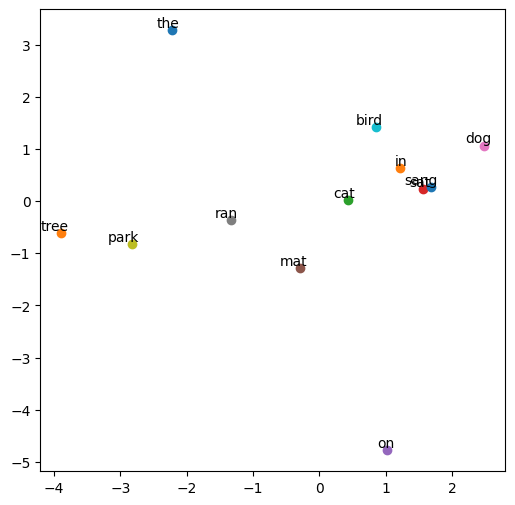

In [95]:
# Get the word embeddings from the trained CBOW model
embeddings = model.get_weights()[0]

# Use PCA to reduce dimensionality
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Visualize the word embeddings
plt.figure(figsize=(6,6))
for i, word in enumerate(tokenizer.word_index.keys()):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(word, (x, y), textcoords="offset points", xytext=(5,2), 
                                                              ha='right')
plt.show()